In [1]:
import tensorflow as tf
import numpy as np
import imageio
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [99]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [100]:
train_images.shape

(60000, 28, 28)

# Visualize Images

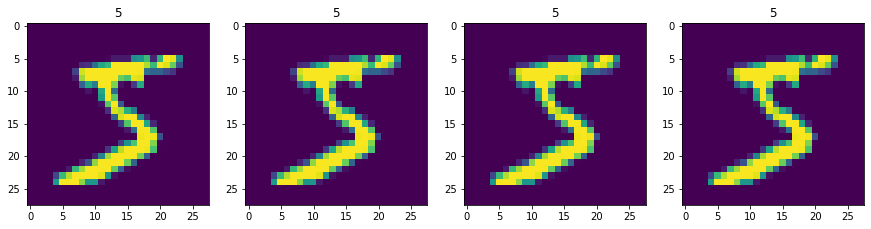

In [101]:
fig, ax = plt.subplots(ncols=4,figsize=(15,15))

for idx in range(4):


  ax[idx].imshow(np.squeeze(train_images[idx,:,:]))
  ax[idx].title.set_text(train_labels[idx])

In [102]:
# Build the dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(128).prefetch(64)


# Build Model

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU
from keras import Model

## Generator

In [150]:
def generator_model():
  model =  Sequential()

  model.add(Dense(500,input_dim=100))
  model.add(Dense(7*7*100,activation='selu'))
  model.add(BatchNormalization())
  model.add(Reshape((7,7,100)))

  # Upsample
  model.add((Conv2DTranspose(64,kernel_size=5,strides=1,padding="same",activation="selu")))
  model.add(BatchNormalization())
  model.add(Conv2D(128,kernel_size=5,padding="same"))


  # Upsample
  model.add((Conv2DTranspose(64,kernel_size=5,strides=2,padding="same",activation="selu")))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=5,padding="same"))

  model.add((Conv2DTranspose(1,kernel_size=5,strides=2,padding="same",activation="tanh")))

  return model


In [151]:
generator = generator_model()

In [152]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 500)               50500     
                                                                 
 dense_14 (Dense)            (None, 4900)              2454900   
                                                                 
 batch_normalization_12 (Bat  (None, 4900)             19600     
 chNormalization)                                                
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 100)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 64)         160064    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 7, 64)        

In [153]:
img = generator.predict(np.random.randn(4,100,1))

1/1 [==============================] - 0s 146ms/step


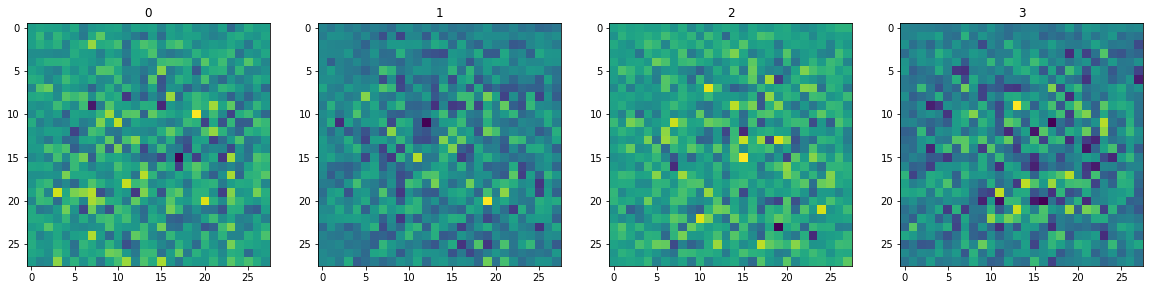

In [154]:
# Show the predicted images

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

## Discriminator

In [155]:
def discriminator_model():
  model = Sequential()

  model.add(Conv2D(64,kernel_size=5,strides=2,padding="same",activation=LeakyReLU(0.2),input_shape=[28,28,1]))
  model.add(Dropout(0.3))
  
  model.add(Conv2D(128,kernel_size=5,strides=2,padding="same",activation=LeakyReLU(0.2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(256,kernel_size=5,strides=2,padding="same",activation=LeakyReLU(0.2)))
  model.add(Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(Dense(1,activation='sigmoid'))

  return model

In [156]:
discriminator = discriminator_model()

In [157]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 256)         819456    
                                                                 
 dropout_11 (Dropout)        (None, 4, 4, 256)         0         
                                                                 
 flatten_3 (Flatten)         (None, 4096)            

In [158]:
discriminator(tf.expand_dims(img,axis=0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4995611]], dtype=float32)>

# Loss Function

In [159]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
from IPython import display

In [160]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [161]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [162]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [163]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Defining Training Loop

In [164]:
batch_size = 128
noise_dim = 100
epochs = 60

In [165]:
@tf.function
def train_step(images):
  real_images = images
  gen_noise = tf.random.normal([batch_size,noise_dim])

  # generate fake images
  generated_images = generator(gen_noise,training=False)

  # Train Discriminator

  with tf.GradientTape() as dis_tape:
    yhat_real = discriminator(real_images,training=True)
    yhat_fake = discriminator(generated_images,training=True)

    d_loss = discriminator_loss(yhat_real,yhat_fake)
    
  # Apply backpropagation - nn learn 
  dgrad = dis_tape.gradient(d_loss, discriminator.trainable_variables) 
  discriminator_optimizer.apply_gradients(zip(dgrad, discriminator.trainable_variables))

  # Train Generator

  with tf.GradientTape() as gen_tape:
    generated_images =  generator(gen_noise,training=True)

    pred_labels = discriminator(generated_images,training=False)

    # Generator loss
    g_loss = generator_loss(pred_labels)

  ggrad = gen_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(ggrad,generator.trainable_variables))

  return d_loss,g_loss

In [166]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if os.path.exists('Images'):
    path = os.path.join('Images','image_at_epoch_{:04d}.png'.format(epoch))

  else:
    os.mkdir('Images')
    path = os.path.join('Images','image_at_epoch_{:04d}.png'.format(epoch))


  plt.savefig(path)
  plt.show()

In [167]:
def train(dataset,epochs):

  d_loss=g_loss=None
  for epoch in range(epochs):
    for img_batch in dataset:

      g_loss,d_loss = train_step(tf.expand_dims(img_batch,axis=-1))

      # Produce images for the GIF as you go
      display.clear_output(wait=True)
      examples = tf.random.normal([16,100])
      generate_and_save_images(generator,
                              epoch + 1,
                              examples)
      
    print(f"EPOCH: {epoch}, disc_loss: {d_loss}, gen_loss{g_loss}\n")
      
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           examples)


# Train the Model

In [1]:
train(train_dataset, epochs)